In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [ ]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print ('Files in Drive:')


Files in Drive:


In [ ]:
cd drive/Finalproject

[Errno 2] No such file or directory: 'drive/Finalproject'
/content


In [ ]:
ls

Calc-Test_P_00038_RIGHT_CC_1/  modelfrom11th.h5  my_model.h5  try.npy
drive/                         modelfrom7th.h5   newcsv.pkl


In [ ]:
import pandas as pd
newcsv=pd.read_pickle("newcsv.pkl") # read the csv
req_content=newcsv[['pathology',"pixel_array"]]  # keep only the required content
req_content=req_content[req_content['pathology']!='BENIGN_WITHOUT_CALLBACK']

In [ ]:
d = {'BENIGN': 0, 'MALIGNANT': 1}                        # Map the labels to 0 and 1
req_content['pathology']=req_content['pathology'].map(d)

In [ ]:
from numpy import array
res_m=req_content[req_content['pathology']== 1]               #    Here we split the dataset equally
res_b=req_content[req_content['pathology']==0]                #
                                                              #
train_m=res_m.sample(frac=0.85,random_state=200)              #
train_b=res_b.sample(frac=0.85,random_state=200)

test_m=res_m.drop(train_m.index)
test_b=res_b.drop(train_b.index)

train=pd.concat([train_m,train_b]).sample(frac=1,random_state=19)
test=pd.concat([test_m,test_b]).sample(frac=1,random_state=19)

train_images=array((train["pixel_array"]).tolist())         # first convert the series to list 
test_images=array(test["pixel_array"].tolist())             # and then convert it into a numpy array

train_labels=train["pathology"].tolist()                      # 
test_labels=test["pathology"].tolist()                        #

import skimage.color as color
train_images=color.gray2rgb(train_images)                 # convert from grayscale to color
test_images=color.gray2rgb(test_images)                   # so as to feed it to the neural network 

train_images = train_images.reshape(train_images.shape[0], 224, 224, 3) # reshape the array 
test_images = test_images.reshape(test_images.shape[0], 224, 224, 3)  # (this is the format in 
                                                                      # which keras accepts data)
#train_images = array(train_images)

train_images =train_images.astype('float32')
test_images= test_images.astype('float32')

train_images/=255          #  Pixel normalization (important)
test_images/=255           #  
print(len(test))
print(len(train))

799
4525


In [ ]:
a=np.array([0,9])
a[np.newaxis].shape

(1, 2)

In [ ]:
#from sklearn.utils import class_weight
#class_weight = class_weight.compute_class_weight('balanced',
#                                                 np.unique(train_labels),
#                                                 train_labels)

NameError: ignored

In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input,Dense,BatchNormalization,Flatten,Dropout,GlobalAveragePooling2D
from keras.models import Model,load_model
from keras.utils import layer_utils
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


In [ ]:
epochs=3

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)  #load the inception model
                                                                  #without the last FC layer
x = base_model.output                                 
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
m = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in m.layers[:165]:
  layer.trainable = False
for layer in m.layers[165:]:
  layer.trainable = True

In [ ]:

m.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_info = m.fit(x=train_images, y=train_labels,batch_size=130 , epochs=epochs, 
                   verbose=1,validation_data=(test_images,test_labels))


Train on 4525 samples, validate on 799 samples
Epoch 1/3
4525/4525 [==============================] - 71s 16ms/step - loss: 0.6996 - acc: 0.5372 - val_loss: 0.6847 - val_acc: 0.5557
Epoch 2/3
4525/4525 [==============================] - 52s 11ms/step - loss: 0.6115 - acc: 0.6650 - val_loss: 0.7670 - val_acc: 0.5432
Epoch 3/3
4525/4525 [==============================] - 52s 11ms/step - loss: 0.4014 - acc: 0.8155 - val_loss: 0.7476 - val_acc: 0.5394


In [ ]:
m= load_model("modelfrom11th.h5")

In [ ]:
val=m.predict(test_images)

In [ ]:
x=12
print("Prediction by our model")
if val[x]<0.5:
    k=0
    print ("\t Benign")
else:
    k=1
    print ("\t Malignant")

print("The actual result")
if test_labels[x]==1:
    print("\t Malignant")
else:
    print("\t Benign")

    
if k==test_labels[x]:
  print("\t Model got it right")
else:
  print("\t Model got it wrong")

Prediction by our model
	 Malignant
The actual result
	 Malignant
	 Model got it right


In [ ]:
### Use round(x) here instead of the function
x=6
if val[x]<0.5:
    k=0
    print ("\t Benign")
else:
    k=1 
    print ("\t Malignant")

	 Malignant


In [ ]:
bindex=[]                  
mindex=[]
for x in range(len(val)):   ### Use round(x) here instead of the function
  if val[x]<0.5:
    bindex.append(x)
  else:
    mindex.append(x)

In [ ]:
test_labels[x]

1

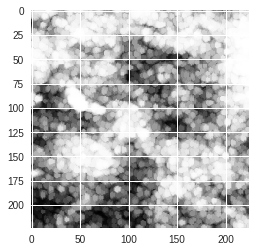

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(test_images[8])

In [ ]:
checked_labels=[0]* array(test_labels)
checked_labels[bindex]=0
checked_labels[mindex]=1

In [ ]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(test_labels , checked_labels)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',      
                          cmap=None,
                          normalize=True):
  
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

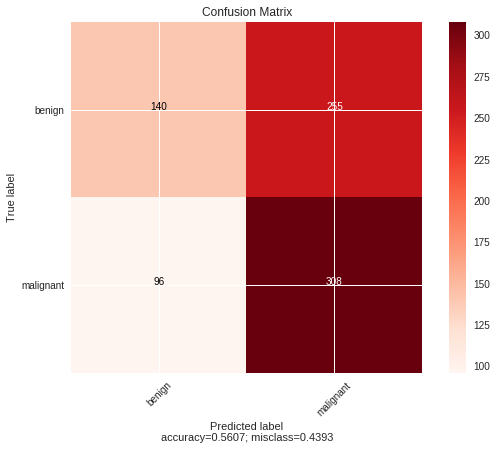

In [ ]:
plot_confusion_matrix(cm = conf, 
                      normalize = False,
                      target_names = ['benign', 'malignant'],
                      title        = "Confusion Matrix")

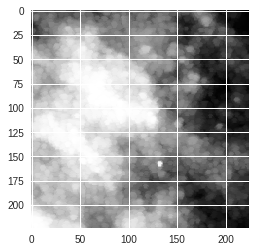

In [ ]:
imgplot = plt.imshow(train_images[5])

In [ ]:
#title Default title text

test_features.shape

(532, 224, 224, 3)

In [ ]:
m.save("modelfrom11th.h5")

In [ ]:
len(val)

799

In [ ]:
#for x in range(len(val)):
#  if val[x]<0.5:
#    if (0==test_labels[x]):
#      print(x)
#  elif val[x] >=0.5:
#    if (1==test_labels[x]):
#      print(x)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom as pdicom #Read mammogram images stored in DICOM files
import cv2

def preprocess_image(path):
    img=pdicom.read_file(path,force=True)
    imgpix=img.pixel_array

    # Scaling 16-bit pixel to 8-bits
    imgpix=((imgpix/65535)*255).astype(np.uint8)

    # Contrast enhancement
    imgpix = cv2.equalizeHist(imgpix)
    
    #dilation
    k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 5))
    k4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 7))
    imgpix= cv2.dilate(imgpix,k1,iterations = 1)
        
    # Resizing image to (224,224)
    imgpix=cv2.resize(imgpix,(224,224))

    return imgpix
#m= load_model("modelfrom11th.h5")

def add_channels(img):
    import skimage.color as color
    img=color.gray2rgb(img)   
    img =img.astype('float32')
    img/=255  
    print(img)#  Pixel normalization (important)          #  
    return img

  
  
img=preprocess_image("000000.dcm")
img=add_channels(img)
pred = m.predict(img[np.newaxis])


[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [1.         1.         1.        ]]

 [[0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [1.         1.         1.        ]]

 [[0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.99215686 0.99215686 0.99215686]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]]

 ...

 [[0.35686275 0.35686275 0.35686275]
  [0.46666667 0.46666667 0.46666667]
  [0.49803922 0.49803922 0.49803922]
  ...
  [0.99215686 0.99215686 0.99215686]
  [0.9882353  0.9882353  0.9882353 ]
  [0.9882353  0.9882353  0.9882353 ]]

 [[0.35686275 0.35686275 0.35686275]
  [0.4627451  0.4627451  0.4627451 ]


In [ ]:
cd Calc-Test_P_00038_RIGHT_CC_1/

/content/drive/Finalproject/Calc-Test_P_00038_RIGHT_CC_1


In [ ]:
cd 1.3.6.1.4.1.9590.100.1.2.200764632211227648028305709420627883105/

/content/drive/Finalproject/Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.200764632211227648028305709420627883105


In [ ]:
cd 1.3.6.1.4.1.9590.100.1.2.244876997513875090239564803900035037851/

/content/drive/Finalproject/Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.200764632211227648028305709420627883105/1.3.6.1.4.1.9590.100.1.2.244876997513875090239564803900035037851


In [ ]:
!pip install dicom

    100% |████████████████████████████████| 768kB 6.2MB/s 


In [ ]:
pred

array([[0.01877405]], dtype=float32)